Many American cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

[Hadi Fanaee-T](http://www.liaad.up.pt/area/fanaee) at the [University of Porto](https://sigarra.up.pt/up/pt/web_base.gera_pagina?p_pagina=home) compiled this data into a CSV file, which we'll be working with in this project. The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. We can download the data from the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset). 

In [54]:
import pandas as pd
import numpy as np

bike_rentals = pd.read_csv("bike_rental_hour.csv")
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Here are the descriptions for the relevant columns:

* instant - A unique sequential ID number for each row
* dteday - The date of the rentals
* season - The season in which the rentals occurred
* yr - The year the rentals occurred
* mnth - The month the rentals occurred
* hr - The hour the rentals occurred
* holiday - Whether or not the day was a holiday
* weekday - The day of the week (as a number, 0 to 7)
* workingday - Whether or not the day was a working day
* weathersit - The weather (as a categorical variable)
* temp - The temperature, on a 0-1 scale
* atemp - The adjusted temperature
* hum - The humidity, on a 0-1 scale
* windspeed - The wind speed, on a 0-1 scale
* casual - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
* registered - The number of registered riders (people who had already signed up)
* cnt - The total number of bike rentals (casual + registered)

In this project, we'll try to predict the total number of bikes people rented in a given hour. We'll predict the cnt column using all of the other columns, except for casual and registered. To accomplish this, we'll create a few different machine learning models and evaluate their performance.

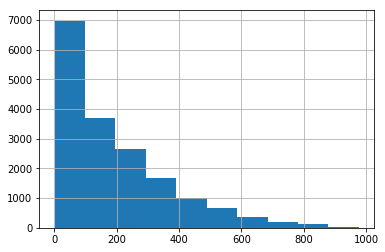

In [26]:
# histogram of the cnt column
import matplotlib.pyplot as plt

bike_rentals["cnt"].hist()
plt.show()

In [27]:
# corr method to explore how each column is correlated with cnt.

bike_rentals.corr()["cnt"]

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

It can often be helpful to calculate features before applying machine learning models. Features can enhance the accuracy of models by introducing new information, or distilling existing information.

For example, the hr column in bike_rentals contains the hours during which bikes are rented, from 1 to 24. A machine will treat each hour differently, without understanding that certain hours are related. We can introduce some order into the process by creating a new column with labels for morning, afternoon, evening, and night. This will bundle similar times together, enabling the model to make better decisions.

In [41]:
def assign_label(hour):
    if 0 <= hour < 6:
        return 4
    elif 6 <= hour < 12:
        return 1
    elif 12 <= hour < 18:
        return 2
    elif 18 <= hour < 24:
        return 2

In [42]:
bike_rentals["time_label"] = bike_rentals["hr"].apply(assign_label)

# Error metric

We will use mean squared error metric in this project. The mean squared error metric makes the most sense to evaluate our error. MSE works on continuous numeric data, which fits our data quite well.

In [43]:
# 80% of the rows in bike_rentals to be part of the training set

train = bike_rentals.sample(frac = 0.8, random_state = 1)

This line will generate a Boolean series that's False when a row in bike_rentals isn't found in train: 

bike_rentals.index.isin(train.index)

In [44]:
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)] #This line will select any rows in bike_rentals that aren't found in train

Now that we've done some exploration and manipulation, we're ready to apply linear regression to the data. Linear regression will probably work fairly well on this data, given that many of the columns are highly correlated with cnt.

As we learned, linear regression works best when predictors are linearly correlated to the target and also independent -- in other words, they don't change meaning when we combine them with each other. The good thing about linear regression is that it's fairly resistant to overfitting because it's straightforward. It also can be prone to underfitting the data, however, and not building a powerful enough model. This means that linear regression usually isn't the most accurate option.

We'll need to ignore the casual and registered columns because cnt is derived from them. If we're trying to predict the number of people who rent bikes in a given hour (cnt), it doesn't make sense that we'd already know casual or registered, because those numbers are added together to get cnt.

In [45]:
from sklearn.linear_model import LinearRegression

In [46]:
# list of predictor columns to use in training and predictions

predictors = list(train.columns)
predictors.remove("cnt")
predictors.remove("casual")
predictors.remove("registered")
predictors.remove("dteday")

In [50]:
reg = LinearRegression()

reg.fit(train[predictors], train["cnt"])
predictions = reg.predict(test[predictors])

In [51]:
from sklearn.metrics import mean_squared_error

In [52]:
error = mean_squared_error(test["cnt"], predictions)
error

17249.33215470395

In [55]:
# caluculation of mse manually
error = np.mean((test["cnt"] - predictions)**2)
error

17249.33215470393

The error is very high, which may be due to the fact that the data has a few extremely high rental counts, but otherwise mostly low counts. Larger errors are penalized more with MSE, which leads to a higher total error.

# Decision Tree

Now we're ready to apply the decision tree algorithm. We'll be able to compare its error with the error from linear regression, which will enable us to pick the right algorithm for this data set.

Decision trees tend to predict outcomes much more reliably than linear regression models. Because a decision tree is a fairly complex model, it also tends to overfit, particularly when we don't tweak parameters like maximum depth and minimum number of samples per leaf. Decision trees are also prone to instability -- small changes in the input data can result in a very different output model.

In [56]:
from sklearn.tree import DecisionTreeRegressor

reg = DecisionTreeRegressor(min_samples_leaf = 5)
reg.fit(train[predictors], train["cnt"])
predictions = reg.predict(test[predictors])

In [57]:
error = mean_squared_error(test["cnt"], predictions)
error

2736.5497805381847

By taking the nonlinear predictors into account, the decision tree regressor appears to have much higher accuracy than linear regression

# Random Forest

We can now apply the random forest algorithm, which improves on the decision tree algorithm. Random forests tend to be much more accurate than simple models like linear regression. Due to the way random forests are constructed, they tend to overfit much less than decision trees. Random forests can still be prone to overfitting, though, so it's important to tune parameters like maximum depth and minimum samples per leaf.

In [61]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(min_samples_leaf=5)
reg.fit(train[predictors], train["cnt"])
predictions = reg.predict(test[predictors])

error = mean_squared_error(test["cnt"], predictions)
error

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


2181.7604895251275

By removing some of the sources of overfitting, the random forest accuracy is improved over the decision tree accuracy.